
# Linear regression example using Spike-Slab Prior

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution. The problem is solved via sampling using emcee.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# local imports (inference data post-processing)
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot

We start by generating a synthetic data set from a known linear model to which we will
add some noise.



In [2]:
# ground truth that is to be inferred
a_true = 8
b_true = 10

# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1 # is assumed to be known and is not inferred.

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test + b_true #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



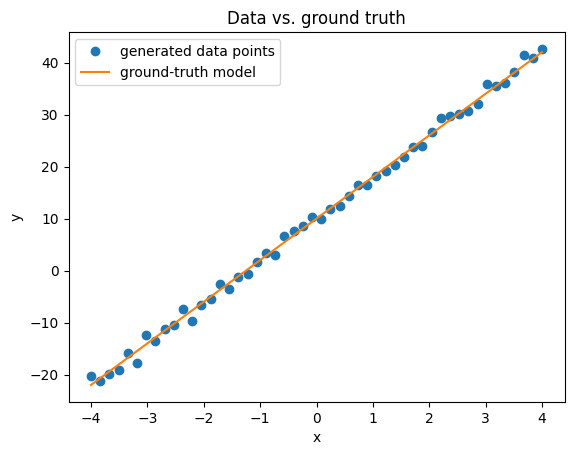

In [3]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
#plt.plot(x_test, - 2*x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Starting values for the parameters are selected using priors. Parameters.json file contatins the list of parameters and their definition.



In [4]:
import json
with open('parameters_playbook.json', 'r') as f: 
    json_object = json.loads(f.read()) 

nwalkers = 20
ndim = len(json_object.get('parameters')) 
from scipy.stats import invgamma, halfcauchy, norm, bernoulli, uniform
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    if parameter['prior'][0] == 'Bernoulli':
        start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    elif parameter['prior'][0] == 'Spike-Slab':
        for hyperparameter in parameter['hyperparameters']:
            for ind, param in enumerate(json_object.get('parameters')):
                if hyperparameter == param['name']:
                    lmbda = start_parameters[:, ind]
        start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   


Defining the log likelihood, log prior functions and using emcee to run the inference problem.

In [5]:
def log_likelihood(theta, _x_test, _y_test, _sigma):
    # Model output - Change thetas over here if changes in parameters are made in json file.
    #if theta[0] >= 0.5:
    y_model =  theta[0] * _x_test + theta[1] #10 * 
    #elif theta[0] < 0.5:
    #    theta[1] = 0
    #    y_model = 10
    return -0.5 * np.sum((_y_test - y_model) ** 2 / _sigma**2 + np.log(_sigma**2))

from scipy.stats import invgamma, halfcauchy, norm, bernoulli

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Bernoulli':
            ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
            #if theta[index] >= 0.3:
            #    theta[index] = 1
            #else:
            #    theta[index] = 0
            if theta[index] < 0.0 or theta[index] > 1.0:
                return -np.inf
            _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
            #_lp += bernoulli.logpmf(theta[index], p = parameter['prior'][1]["p"])
        elif parameter['prior'][0] == 'Spike-Slab':
            for hyperparameter in parameter['hyperparameters']:
                for ind, param in enumerate(json_object.get('parameters')):
                    if hyperparameter == param['name']:
                        lmbda = theta[ind]
                        #if lmbda < 0.0 or lmbda > 1.0:
                        #    return -np.inf
            #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 
            #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
            if lmbda >= 0.5:
                _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
            elif lmbda < 0.5:
                theta[index] = 0
                _lp += 0
            #else:
            #    return -np.inf
        
        elif parameter['prior'][0] == 'Normal': 
            _lp+= norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 

        elif parameter['prior'][0] == 'Uniform':   
            _lp+= uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
    
    return _lp
            

def log_probability(theta, _x_test, _y_test, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, _x_test, _y_test, _std_noise)

start_parameters = np.zeros((nwalkers, ndim))
start_parameters[:, 0] = np.random.uniform(7,9, nwalkers)
start_parameters[:, 1] = np.random.uniform(9,11, nwalkers)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_test, y_test, std_noise))
sampler.run_mcmc(start_parameters, 5000, progress=True)

100%|██████████| 5000/5000 [00:13<00:00, 357.26it/s]


State([[0.2086497  0.05882906]
 [0.20006273 0.0400396 ]
 [0.20070274 0.03962698]
 [0.21823313 0.04662392]
 [0.19820958 0.05218578]
 [0.21931921 0.04711411]
 [0.20283314 0.0514228 ]
 [0.21996318 0.05327332]
 [0.22773116 0.07121338]
 [0.21322346 0.05691837]
 [0.22015186 0.05628059]
 [0.18179371 0.06490149]
 [0.21667543 0.04658996]
 [0.21815406 0.04193921]
 [0.22093633 0.0469341 ]
 [0.2068065  0.04421083]
 [0.22034821 0.05046079]
 [0.24196114 0.04703977]
 [0.20306511 0.04903131]
 [0.20732185 0.05918001]], log_prob=[-11243.44387421 -11244.63244341 -11244.56099481 -11242.67173694
 -11244.55196569 -11242.67332964 -11243.7323663  -11242.72329351
 -11245.51179836 -11242.9808179  -11242.88414228 -11250.31725238
 -11242.67217744 -11242.9226495  -11242.72307886 -11243.34893111
 -11242.67073596 -11245.75220349 -11243.68338589 -11243.60567428], blobs=None, random_state=('MT19937', array([3763065928, 1763904413, 3222065857,  953897458,  786654875,
       4108619990,  604995281, 1584605369, 286390321

Plotting the trace of the chain

Text(0.5, 0, 'step number')

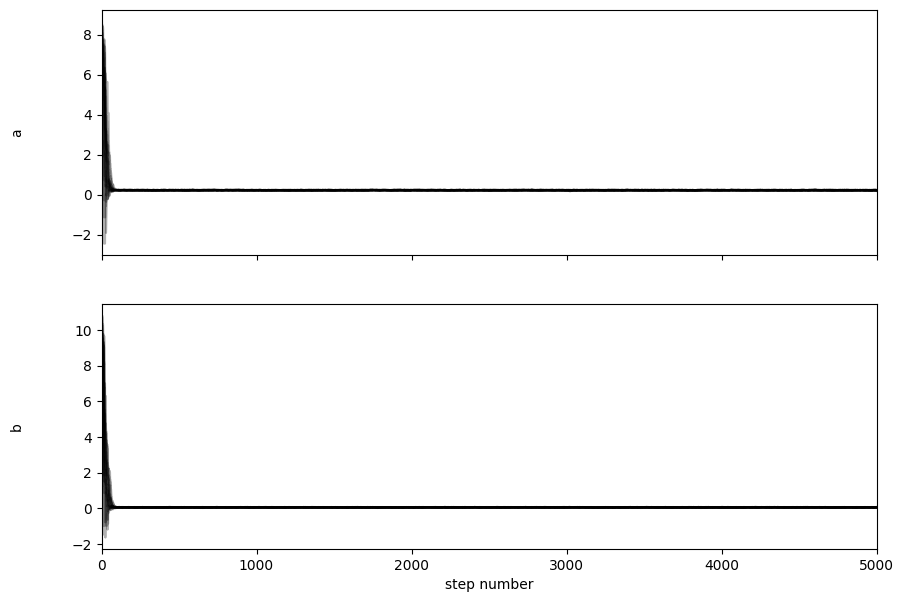

In [6]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Plotting the pair-plot of the chain.

In [ ]:
flat_samples = sampler.get_chain(discard=4998)

In [ ]:
flat_samples[1,:,[0,1]]

In [ ]:
flat_samples[:,[0,11],:]

In [ ]:
flat_samples[:,[0,11],4]

In [ ]:
flat_samples1[1,:,[4,5]]

In [ ]:
flat_samples1 = sampler.get_chain(discard=4998)

In [ ]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)
import corner
labels = ["lmbda_a", "a", "lmbda_b", "b"]  # Change the labels over here if changes in parameters are made in json file.
fig = corner.corner(
    flat_samples, labels=labels, truths=[1, 8, 1, 10]
)